16.1 Given the PnL series on N investment strategies:   
(a) Align them to the average frequency of their bets (e.g.,weekly observations  
for strategies that trade on aweekly basis).Hint:This kind of data alignment  
is sometimes called “downsampling.”  

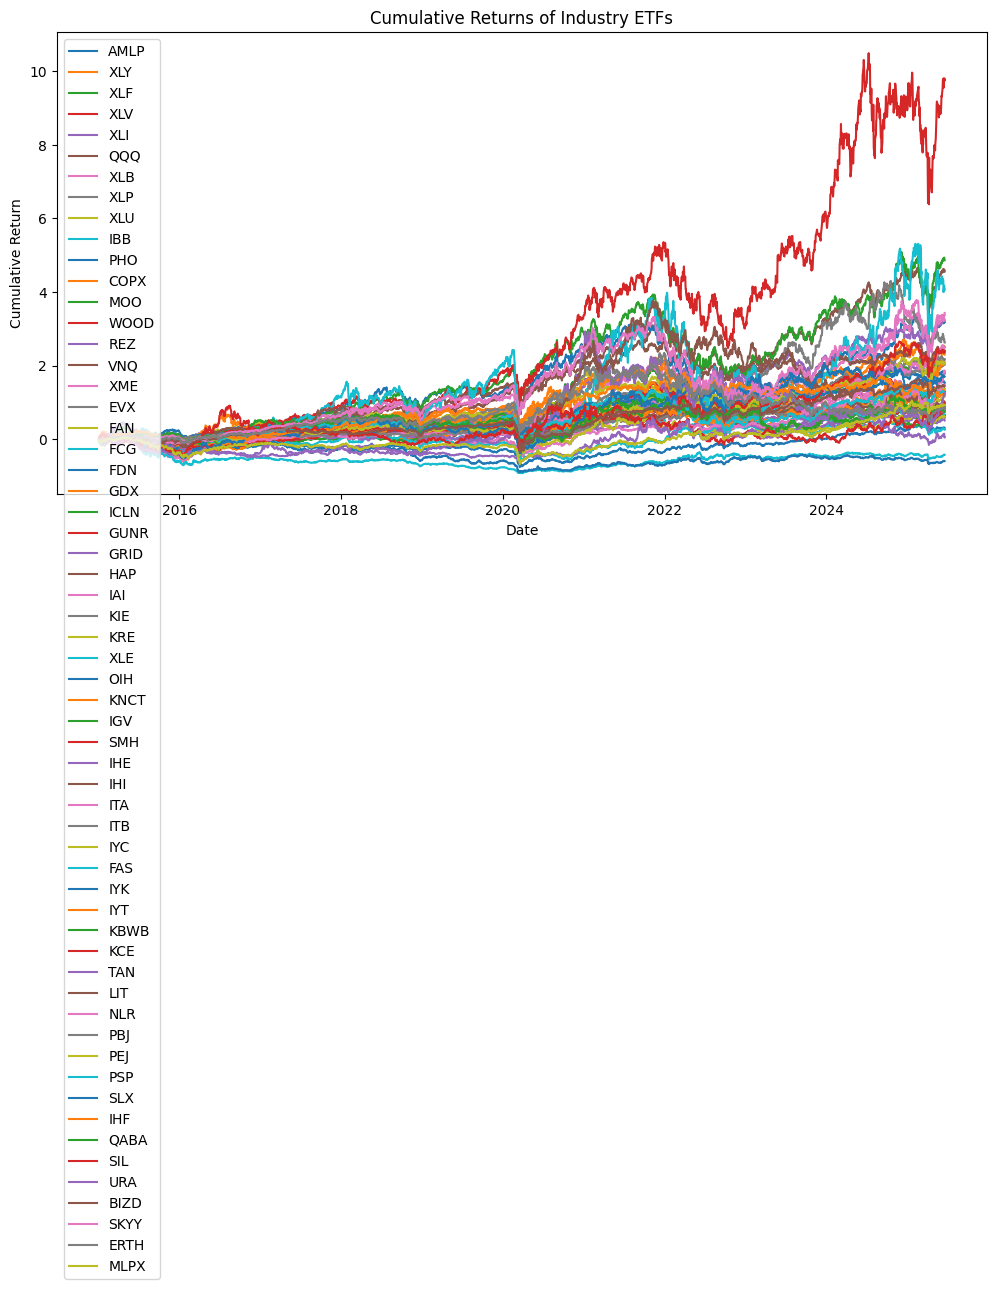

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

industry_etf_price = pd.read_csv("industry_etf_price.csv", index_col=0, parse_dates=True)
industry_etf_price = industry_etf_price['2015-01-01':]  # Filter data from 2015 onwards
industry_etf_price = industry_etf_price.dropna(axis=1, how='any')

industry_etf_pnl = (1+industry_etf_price.pct_change().dropna(how='any')).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(industry_etf_pnl)
plt.title("Cumulative Returns of Industry ETFs")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend(industry_etf_pnl.columns, loc="upper left")
plt.show()


(b) Compute the covariance of their returns, V.

In [2]:
V=industry_etf_price.pct_change().dropna(how='any').cov()

(c) Identify the hierarchical clusters among the N strategies.

/var/folders/4t/tqsscz0s6wn8sp8kh0264n680000gn/T/ipykernel_78923/2037328677.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked=linkage(dist, method='complete')


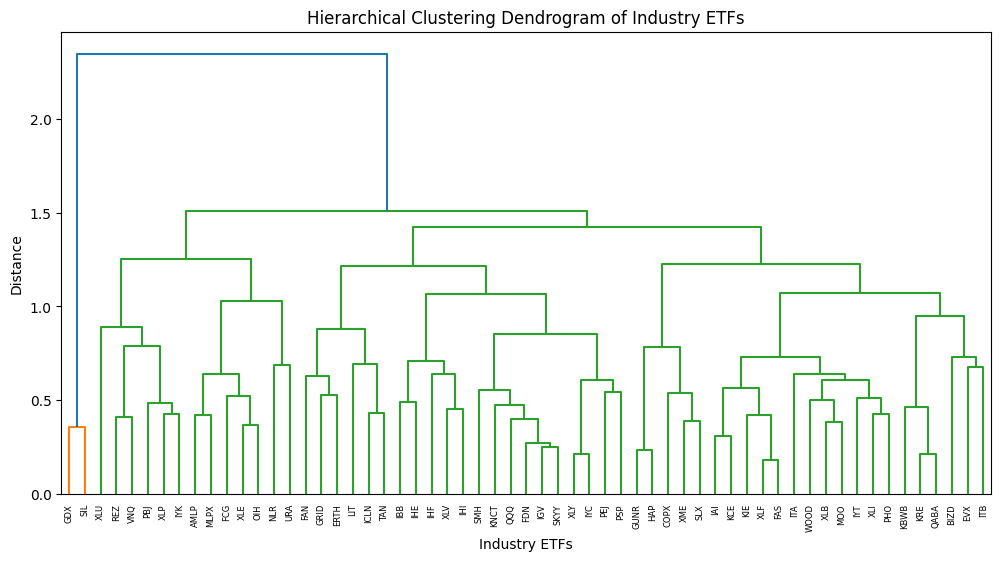

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage

corr= industry_etf_price.pct_change().dropna(how='any').corr()
dist=np.sqrt((1-corr)/2)
linked=linkage(dist, method='complete')
plt.figure(figsize=(12, 6))
dendrogram(linked, labels=industry_etf_price.columns)
plt.title("Hierarchical Clustering Dendrogram of Industry ETFs")
plt.xlabel("Industry ETFs")
plt.ylabel("Distance")
plt.show()

(d) Plot the clustered correlation matrixof the N strategies.

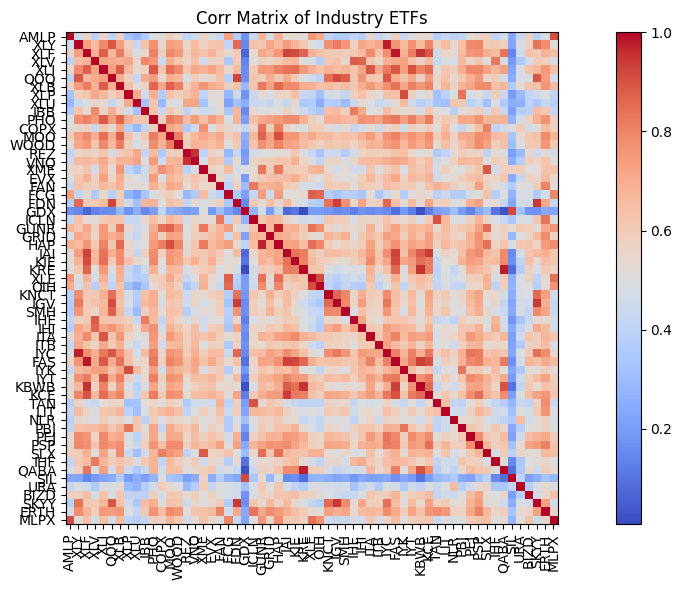

In [4]:
plt.figure(figsize=(12, 6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title("Corr Matrix of Industry ETFs")
plt.xticks(ticks=np.arange(len(industry_etf_price.columns)), labels=industry_etf_price.columns, rotation=90)
plt.yticks(ticks=np.arange(len(industry_etf_price.columns)), labels=industry_etf_price.columns)
plt.tight_layout()
plt.show()

16.2 Using the clustered covariance matrix V from exercise 1: 

(a) Compute the HRP(Hierarchical Risk Parity) allocations

/var/folders/4t/tqsscz0s6wn8sp8kh0264n680000gn/T/ipykernel_78923/2909845126.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link=sch.linkage(dist, method='single')


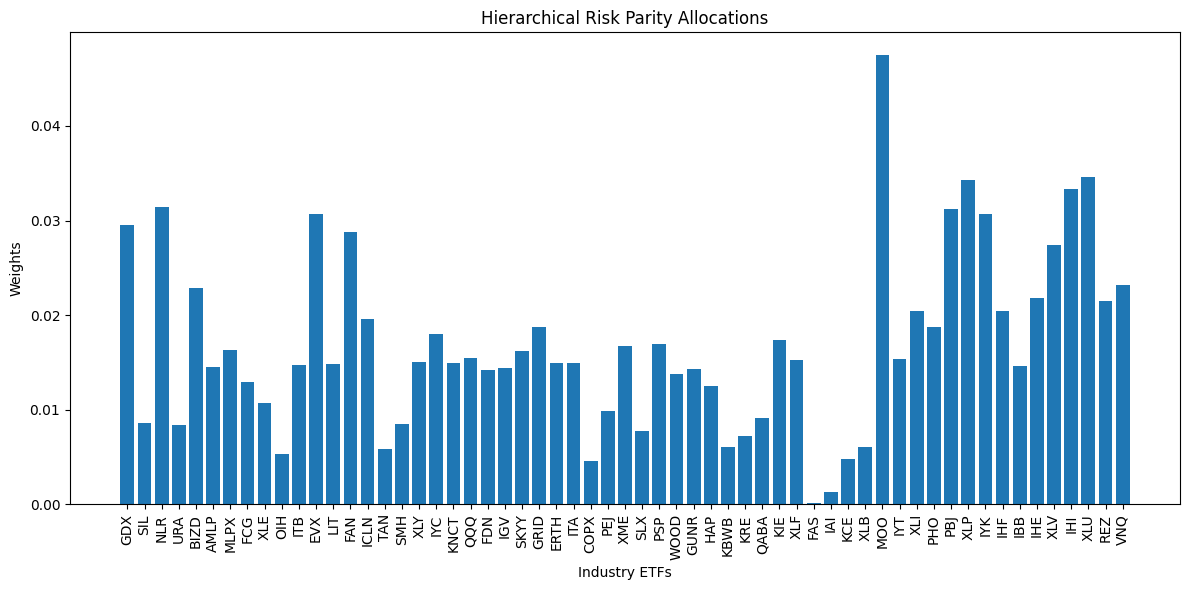

In [5]:
import scipy.cluster.hierarchy as sch

corr= industry_etf_price.pct_change().dropna(how='any').corr()
dist=np.sqrt((1-corr)/2)
link=sch.linkage(dist, method='single')

def get_quasi_diagonal_matrix_list(link)->list:
    link=link.astype(int)
    sort_idx=pd.Series([link[-1, 0], link[-1, 1]])
    num_items=link[-1, 3]
    while sort_idx.max()>=num_items:
        sort_idx.index=range(0,sort_idx.shape[0]*2,2) # make space
        df0=sort_idx[sort_idx>=num_items] # find clusters
        i=df0.index;j=df0.values-num_items
        sort_idx[i]=link[j,0] # item 1
        df0=pd.Series(link[j,1],index=i+1)
        sort_idx=pd.concat([sort_idx, df0])
        sort_idx=sort_idx.sort_index() # re-sort
        sort_idx.index=range(sort_idx.shape[0]) # re-index
    return sort_idx.tolist()

def get_recursive_bisection(cov, sort_idx):
    w=pd.Series(1.0, index=sort_idx)
    cluster_items=[sort_idx]
    def get_cluster_variance(cov, cluster_items):
        cur_cov=cov.iloc[cluster_items, cluster_items]
        weights=1/np.diag(np.linalg.inv(cur_cov))
        weights=weights/weights.sum()
        return weights.T @ cur_cov @ weights
    
    while len(cluster_items)>0:
        # half size of cluster that preserves the order
        cluster_items=[c[s:e] for c in cluster_items for s, e in ((0, len(c)//2), (len(c)//2, len(c))) if len(c)>1]
        for i in range(0, len(cluster_items), 2):
            c1=cluster_items[i]
            c2=cluster_items[i+1]
            c1_var=get_cluster_variance(cov, c1)
            c2_var=get_cluster_variance(cov, c2)

            # more weight to the cluster with lower variance
            split_factor=1- c1_var/(c1_var+c2_var)
            w[c1] *= split_factor
            w[c2] *= 1-split_factor
    return w


sort_idx=get_quasi_diagonal_matrix_list(link)
w_hrp=get_recursive_bisection(V, sort_idx)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(V.index[w_hrp.index], w_hrp.values)
plt.title("Hierarchical Risk Parity Allocations")
plt.xlabel("Industry ETFs")
plt.ylabel("Weights")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

(b) Compute the CLA(Critical Line Algorithm) allocations

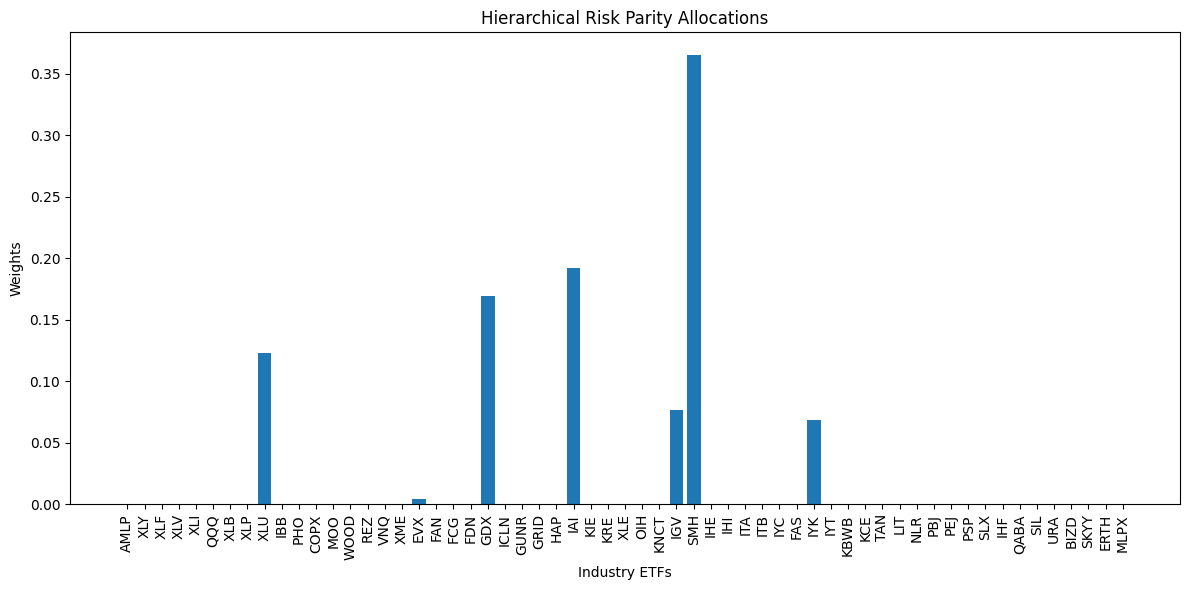

In [6]:
import cvxpy as cp

def get_cla_weights(var):
    mu= industry_etf_price.pct_change().dropna(how='any').mean()
    target_returns=np.linspace(mu.min(), mu.max(), 1000)
    pd_froniter=pd.DataFrame()
    for target_return in target_returns:
        w=cp.Variable(len(mu))
        portfolio_return=w.T @ mu
        portfolio_variance=w.T @ var @ w
        objective=cp.Minimize(portfolio_variance)
        problem=cp.Problem(objective, constraints=[cp.sum(w) == 1, portfolio_return == target_return, w >= 0])
        problem.solve()

        if problem.status == cp.OPTIMAL:
            pd_froniter = pd.concat([pd_froniter, pd.DataFrame({'target_return': [target_return], 'portfolio_variance': [portfolio_variance.value], 'weights':[w.value]})], ignore_index=True)

    pd_froniter['sharpe']= pd_froniter['target_return'] / np.sqrt(pd_froniter['portfolio_variance'])
    w=pd_froniter[pd_froniter['sharpe'] == pd_froniter['sharpe'].max()]['weights'].values[0]
    return w

plt.figure(figsize=(12, 6))
w_cla= get_cla_weights(V)
plt.bar(V.index.values, w_cla)
plt.title("Hierarchical Risk Parity Allocations")
plt.xlabel("Industry ETFs")
plt.ylabel("Weights")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


(c) Compute the IVP(Inverse-Variance Portfolio) allocations

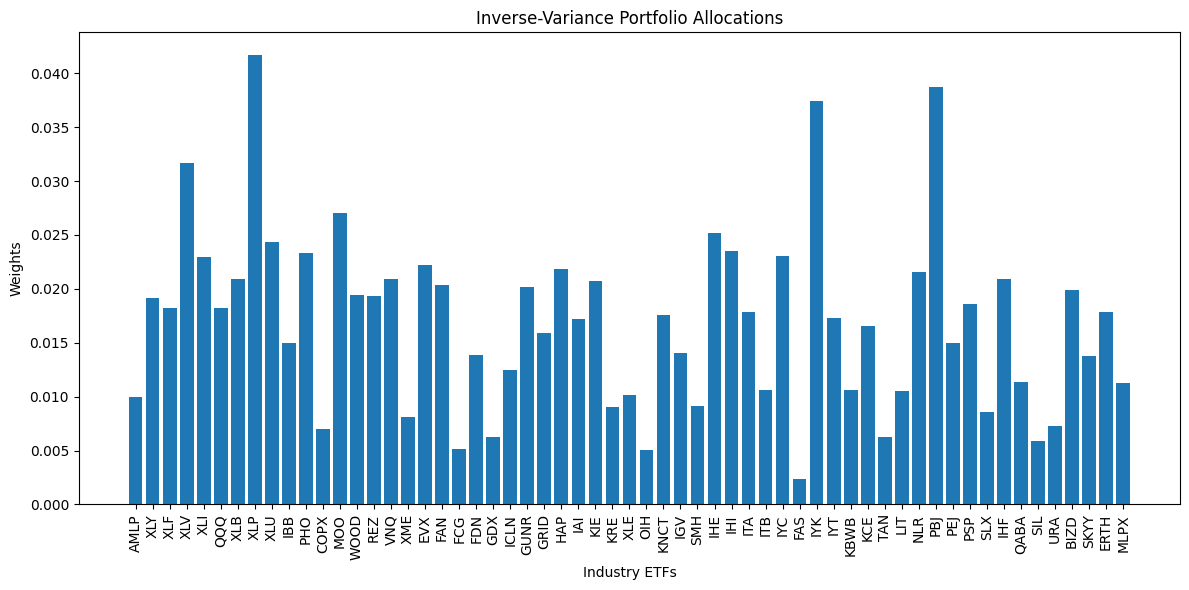

In [7]:
w_ivp= 1/industry_etf_price.pct_change().dropna().var()
w_ivp /= w_ivp.sum()  # Normalize w_ivp to sum to 1

plt.figure(figsize=(12, 6))
plt.bar(V.index, w_ivp)
plt.title("Inverse-Variance Portfolio Allocations")
plt.xlabel("Industry ETFs")
plt.ylabel("Weights")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

16.3 Using the covariance matrix V from exercise 1:

(a) Perform a spectral decomposition: VW= WΛ.

In [8]:
e_val, e_vec = np.linalg.eig(V)
e_val = np.diag(e_val)
print("Eigenvalues:\n", e_val.shape, "Eigen Vectors:\n", e_vec.shape)   

Eigenvalues:
 (59, 59) Eigen Vectors:
 (59, 59)


(b) Form an array $\epsilon$ by drawing N random numbers from a U[0,1] distribution.

In [9]:
epsilon=np.random.uniform(0, 1, len(V))

(c) Form an NxN matrix $\tilde\Lambda$
where
$\tilde\Lambda_{n, n}= N \epsilon_n \Lambda_{n, n}((\sum_{n=1}^N \epsilon_n))^{-1}, n=1,...,N$

In [10]:
simulated_e_vals=[len(epsilon)*e*e_val[i][i]/sum(epsilon) for i, e in enumerate(epsilon)]
simulated_e_vals=np.diag(simulated_e_vals)

(d) Compute $\tilde{V}=W\tilde{\Lambda}W^{-1}$

In [11]:
simulated_var= e_vec @ simulated_e_vals @ e_vec.T
simulated_var = pd.DataFrame(simulated_var, index=V.index, columns=V.columns)

(e) Repeat exercise 2, this time using $\tilde{V}$
as covariance matrix. What allocation  
method has been most impacted by there-scaling of spectral variances?  

CLA가 가장 많은 영향을 받는다. 

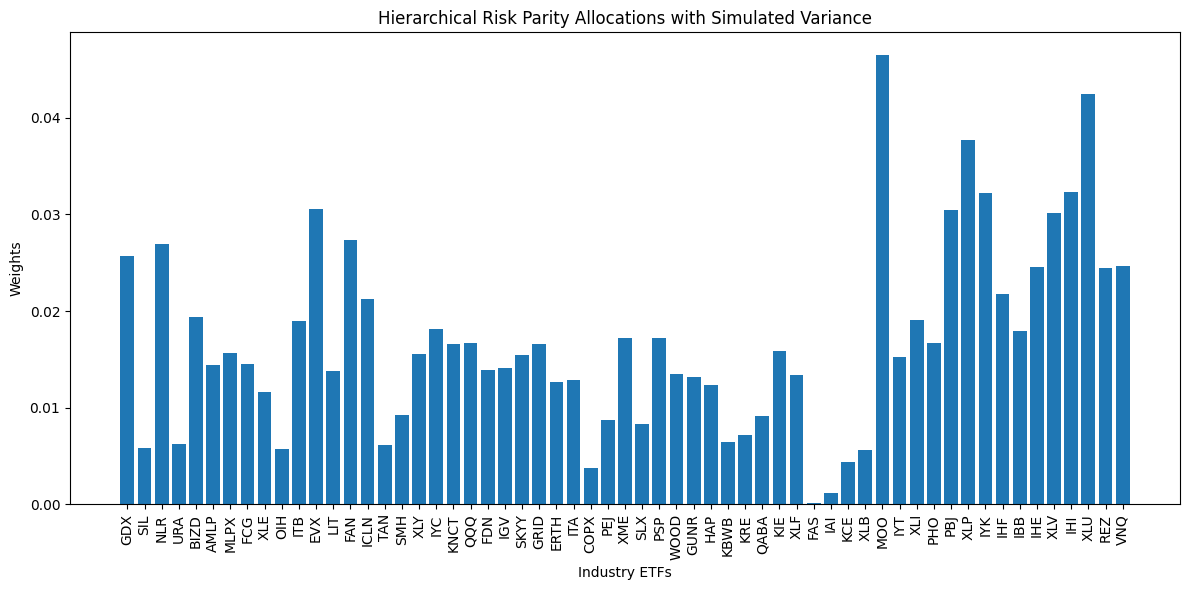

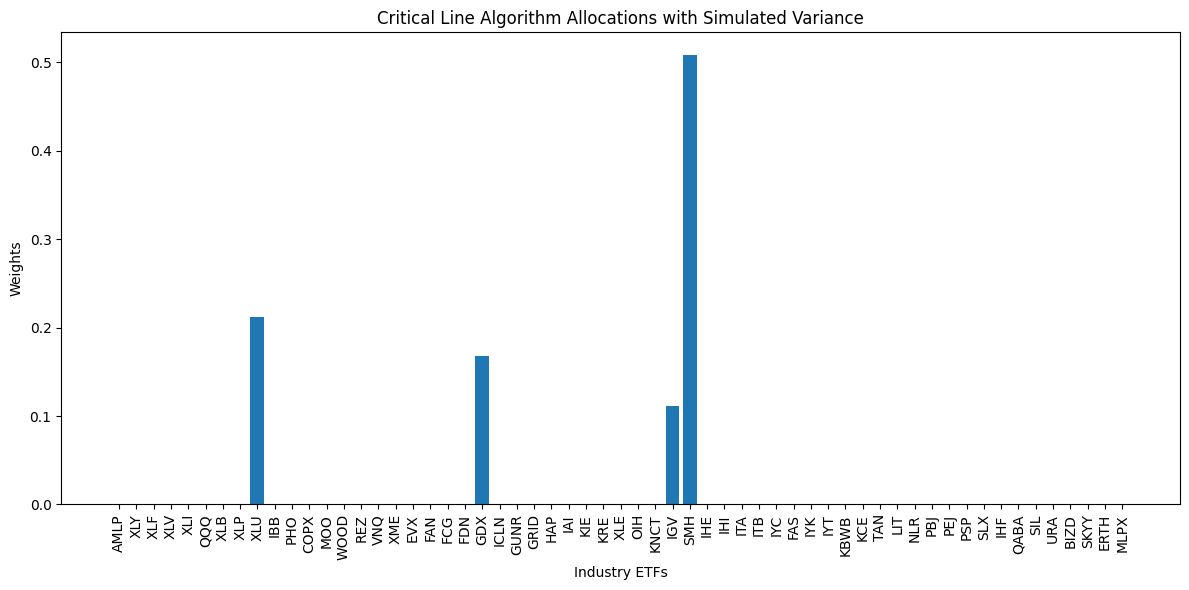

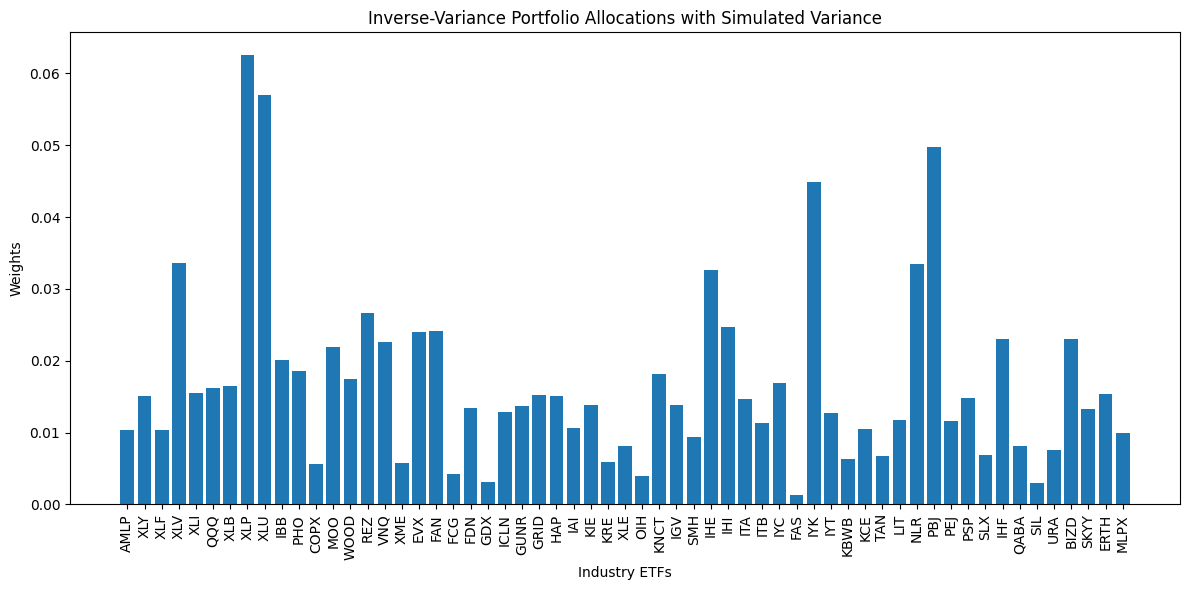

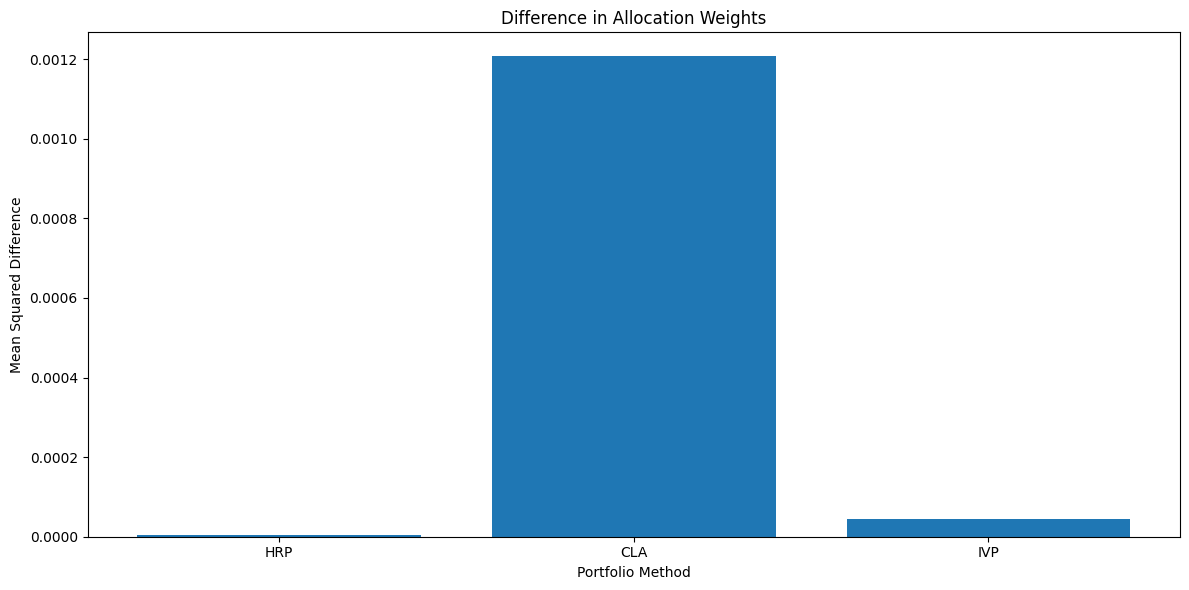

In [12]:
# HRP
sort_idx=get_quasi_diagonal_matrix_list(link)
w_hrp_sim=get_recursive_bisection(simulated_var, sort_idx)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(V.index[w_hrp_sim.index], w_hrp_sim.values)
plt.title("Hierarchical Risk Parity Allocations with Simulated Variance")
plt.xlabel("Industry ETFs")
plt.ylabel("Weights")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# CLA
w_cla_sim=get_cla_weights(simulated_var)
plt.figure(figsize=(12, 6))
plt.bar(V.index.values, w_cla_sim)
plt.title("Critical Line Algorithm Allocations with Simulated Variance")
plt.xlabel("Industry ETFs")
plt.ylabel("Weights")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# IVP
w_ivp_sim= 1/simulated_var.var()
w_ivp_sim /= w_ivp_sim.sum()  # Normalize w_ivp_sim to sum to 1
plt.figure(figsize=(12, 6)) 
plt.bar(V.index, w_ivp_sim)
plt.title("Inverse-Variance Portfolio Allocations with Simulated Variance")
plt.xlabel("Industry ETFs")
plt.ylabel("Weights")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Diff of allocation weights
plt.figure(figsize=(12, 6))
weight_diff=[np.mean((w_b-w_f)**2) for w_b, w_f in zip([w_hrp,w_cla, w_ivp], [w_hrp_sim, w_cla_sim, w_ivp_sim])]
plt.bar(['HRP', 'CLA', 'IVP'], weight_diff)
plt.title("Difference in Allocation Weights")
plt.xlabel("Portfolio Method")
plt.ylabel("Mean Squared Difference")
plt.tight_layout()
plt.show()





16.4 How would you modify the HRP algorithm to produce allocations that add up to 0, where $|w_n| \le 1\ \forall n=1,...,N$  

Bisect의 합치는 과정에서 가중치가 1이 되게 유도를 하고 있으므로 해당 부분의 가중치합이 0이 되게 유도하면 된다. 따라서 처음에 합이 0이 되도록 유도하고 그 안에 포트폴리오를 다시 나누는 방식으로 유도한다.

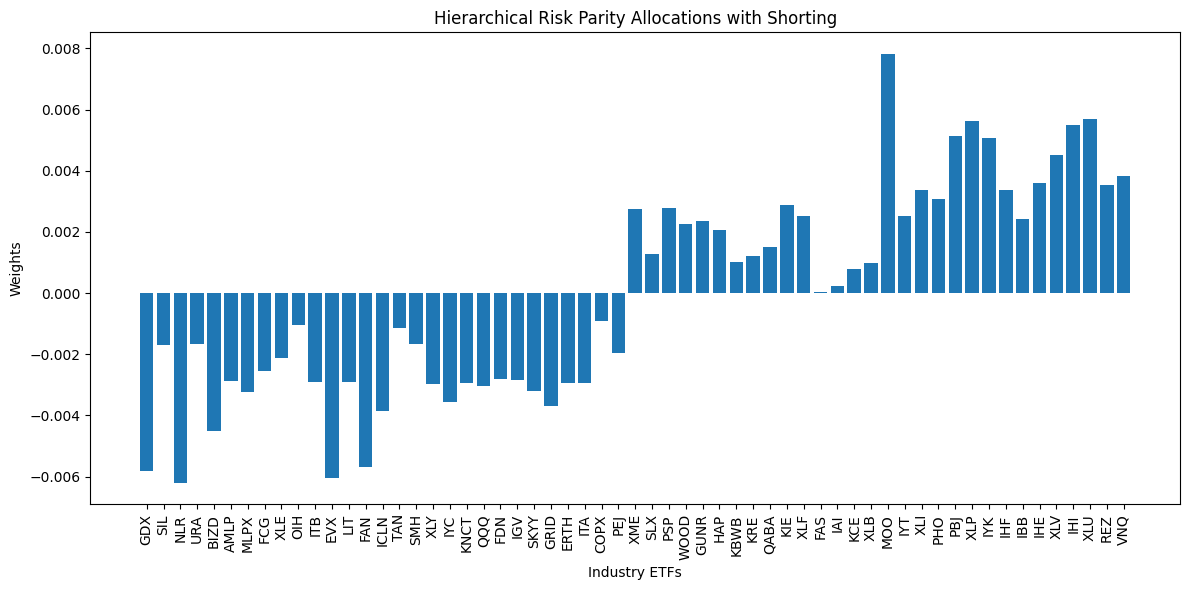

In [13]:
def get_recursive_bisection_with_short(cov:pd.DataFrame, sort_idx:list):
    w=pd.Series(1.0, index=sort_idx)
    cluster_items=[sort_idx]
    def get_cluster_variance(cov, cluster_items):
        cur_cov=cov.iloc[cluster_items, cluster_items]
        weights=1/np.diag(np.linalg.inv(cur_cov))
        weights=weights/weights.sum()
        return weights.T @ cur_cov @ weights
    
    while len(cluster_items)>0:
        # half size of cluster that preserves the order
        cluster_items=[c[s:e] for c in cluster_items for s, e in ((0, len(c)//2), (len(c)//2, len(c))) if len(c)>1]
        for i in range(0, len(cluster_items), 2):
            c1=cluster_items[i]
            c2=cluster_items[i+1]
            c1_var=get_cluster_variance(cov, c1)
            c2_var=get_cluster_variance(cov, c2)

            # more weight to the cluster with lower variance
            total_sum=w[c1].sum() + w[c2].sum()
            if total_sum == len(c1) + len(c2): #initial weights
                split_factor=(c1_var-c2_var)/((c1_var+c2_var))
                split_factor=np.tanh(split_factor)  # Ensure split_factor is between -1 and 1
                w[c1]*= -split_factor
                w[c2]*= split_factor
            else:
                split_factor=1- c1_var/(c1_var+c2_var)
                w[c1]*=split_factor 
                w[c2]*= 1-split_factor
    return w

sort_idx=get_quasi_diagonal_matrix_list(link)
w=get_recursive_bisection_with_short(V, sort_idx)
plt.figure(figsize=(12, 6))
plt.bar(V.index[w.index], w.values)
plt.title("Hierarchical Risk Parity Allocations with Shorting")
plt.xlabel("Industry ETFs")
plt.ylabel("Weights")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

16.5 Can you think of an easy way to incorporate expected returns in the HRP
allocations?

현재는 cluster_variance를 최소화하는 방향으로 최적화를 진행하는데 bisection 과정에서 sharp를 최대화하는 방향으로 최적화를 유도할 수 있다.

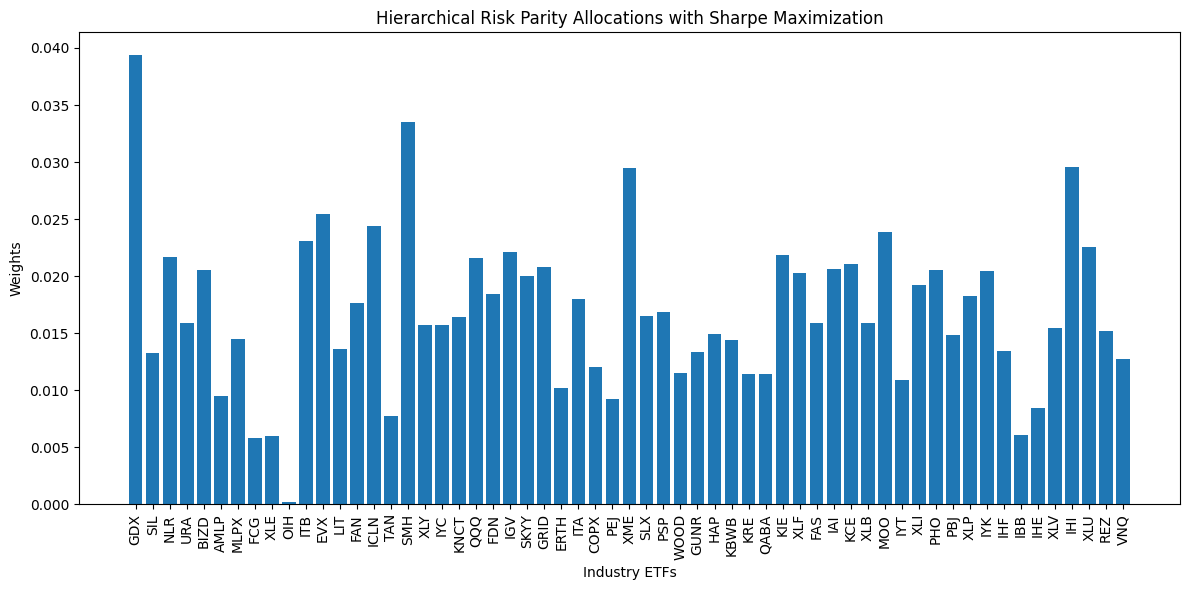

In [14]:
def get_recursive_bisection_sharpe(mean: pd.Series, cov: pd.DataFrame, sort_idx: list):
    w = pd.Series(1.0, index=sort_idx)
    cluster_items = [sort_idx]
    
    def get_cluster_sharpe(mean, cov, cluster_items):
        cur_cov = cov.iloc[cluster_items, cluster_items]
        cur_mean = mean.iloc[cluster_items]
        weights = 1 / np.diag(np.linalg.inv(cur_cov))
        weights = weights / weights.sum()
        return (weights.T @ cur_mean) / np.sqrt(weights.T @ cur_cov @ weights)
    
    while len(cluster_items) > 0:
        # half size of cluster that preserves the order
        cluster_items = [c[s:e] for c in cluster_items for s, e in ((0, len(c)//2), (len(c)//2, len(c))) if len(c) > 1]
        for i in range(0, len(cluster_items), 2):
            c1 = cluster_items[i]
            c2 = cluster_items[i + 1]
            c1_sharpe = get_cluster_sharpe(mean, cov, c1)
            c2_sharpe = get_cluster_sharpe(mean, cov, c2)

            # more weight to the cluster with higher Sharpe ratio
            split_factor = (c1_sharpe) / (c1_sharpe + c2_sharpe)
            w[c1] *= split_factor
            w[c2] *= 1 - split_factor
    return w

mean = industry_etf_price.pct_change().dropna(how='any').mean()
sort_idx = get_quasi_diagonal_matrix_list(link)
w = get_recursive_bisection_sharpe(mean, V, sort_idx)
plt.figure(figsize=(12, 6))
plt.bar(V.index[w.index], w.values)
plt.title("Hierarchical Risk Parity Allocations with Sharpe Maximization")
plt.xlabel("Industry ETFs")    
plt.ylabel("Weights")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()